In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import re
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel
from tqdm import tqdm
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import RandomOverSampler  # Import RandomOverSampler
import unicodedata

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/emotiion-dataset/Dataset.csv


In [3]:
df=pd.read_csv("/kaggle/input/emotiion-dataset/Dataset.csv")
df.head()

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,SL,Emotion,Text,Year,Racial Biases,Hatred Percentage,Depression Percentage
0,1,disgust,নির্বাচনের আগের রাতে সুষ্টু শান্তিপূর্ণ ভাবে ভ...,2016,NaN,NaN,NaN
1,2,disgust,জনগণ মনের আনন্দে নিজেদের ভোট কাস্ট করে দেশদ্রো...,2016,NaN,NaN,NaN
2,3,angry,ভেজাল নির্বাচন ।,2016,NaN,NaN,NaN
3,4,happy,বিএনপি ও রাজাকার সমর্থকরা হেরে গেলে দেশের জন্য...,2016,NaN,NaN,NaN
4,5,angry,"সূক্ষ্ম কারচুপি বলে এতদিন একটা কথার কথা ছিল, এ...",2016,NaN,NaN,NaN


In [4]:
# Divide the dataset into train, dev, and test sets
train_df = df.sample(frac=0.8, random_state=42)  # 80% for training
remaining_df = df.drop(train_df.index)  # Remaining 20%

# Split the remaining 20% into dev (50% of remaining) and test (50% of remaining)
dev_df = remaining_df.sample(frac=0.5, random_state=42)  # 50% of remaining for development
test_df = remaining_df.drop(dev_df.index)  # The rest for testing

# Now you have train_df (80%), dev_df (10%), and test_df (10%)


In [5]:
!pip install bnltk

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.2/79.2 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.9/60.9 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 31.0 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 57.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.5/19.5 MB 72.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 88.8 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.3/615.3 MB 2.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 98.4 MB/s eta 0:00:00:00:01
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.17.1
    Uninstalling tensorboard-2.17.1:
      Successfully uninstalled tensorboard-2.17

In [6]:
from bnltk.stemmer import BanglaStemmer
bn_stemmer = BanglaStemmer()
print(bn_stemmer.stem('হেসেছিলেন'))
# হাসা

হাসা


In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
import os
from transformers import AutoModel, AutoTokenizer, get_linear_schedule_with_warmup
import pandas as pd
import numpy as np
import re
import unicodedata
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import RandomOverSampler

# Set CUDA debugging mode
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

# **Step 1: Apply Random Oversampling to Balance the Datasets**
def oversample_dataset(df):
    # Drop rows where 'text' or 'label' is NaN
    df = df.dropna(subset=['Text', 'Emotion'])

    # Ensure labels are integers using label encoder
    label_encoder = LabelEncoder()
    df["Emotion"] = label_encoder.fit_transform(df["Emotion"])

    ros = RandomOverSampler(random_state=42)
    texts, labels = df["Text"].values.reshape(-1, 1), df["Emotion"].values

    texts_resampled, labels_resampled = ros.fit_resample(texts, labels)

    balanced_df = pd.DataFrame({"Text": texts_resampled.flatten(), "Emotion": labels_resampled})
    return balanced_df

# Apply oversampling after fixing NaN issues
train_df = oversample_dataset(train_df)
dev_df = oversample_dataset(dev_df)
test_df = oversample_dataset(test_df)

In [8]:
#step-2
from bnltk.stemmer import BanglaStemmer
stemmer = BanglaStemmer()


def preprocess_text(text):
    text = unicodedata.normalize('NFKC', text)
    text = re.sub(r'[০-৯]', '[NUMBER]', text)
    text = re.sub(r'http\S+|www\S+', '[URL]', text)
    text = re.sub(r'[^\u0980-\u09FF\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    words = text.split()
    lemmatized_words = [stemmer.stem(word) for word in words]
    return ' '.join(lemmatized_words)



In [9]:
# **Step 3: Define Dataset Class**
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=70):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        encoding = self.tokenizer(
            text,
            padding="max_length",
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt"
        )

        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "label": torch.tensor(label, dtype=torch.long)
        }


In [10]:
# **Step 4: Define CAPTAIN Model (Capsule Network + BanglaBERT)**
class CapsuleLayer(nn.Module):
    def __init__(self, num_capsules, input_dim, output_dim, routing_iterations=3):
        super(CapsuleLayer, self).__init__()
        self.num_capsules = num_capsules
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.routing_iterations = routing_iterations
        self.weights = nn.Parameter(torch.randn(num_capsules, input_dim, output_dim))

    def forward(self, x):
        x = x.unsqueeze(1).expand(-1, self.num_capsules, -1, -1)
        u_hat = torch.matmul(x, self.weights)

        b_ij = torch.zeros(u_hat.shape[0], self.num_capsules, u_hat.shape[2]).to(x.device)

        for _ in range(self.routing_iterations):
            c_ij = torch.nn.functional.softmax(b_ij, dim=1)
            s_j = (c_ij.unsqueeze(-1) * u_hat).sum(dim=2)
            v_j = self.squash(s_j)
            b_ij = b_ij + (u_hat * v_j.unsqueeze(2)).sum(dim=-1)

        return v_j

    @staticmethod
    def squash(tensor):
        norm = (tensor ** 2).sum(dim=-1, keepdim=True)
        scale = norm / (1 + norm)
        return scale * tensor / torch.sqrt(norm + 1e-8)

class CAPTAINModel(nn.Module):
    def __init__(self, num_classes=6):
        super(CAPTAINModel, self).__init__()
        self.bert = AutoModel.from_pretrained("csebuetnlp/banglabert")
        self.capsule = CapsuleLayer(num_capsules=8, input_dim=768, output_dim=16)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(8 * 16, 128)
        self.fc2 = nn.Linear(128, num_classes)
        self.batch_norm = nn.BatchNorm1d(128)
        self.dropout = nn.Dropout(0.5)

    def forward(self, input_ids, attention_mask):
        bert_output = self.bert(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state
        caps_output = self.capsule(bert_output)
        flat_output = self.flatten(caps_output)
        x = self.batch_norm(torch.relu(self.fc1(flat_output)))
        x = self.dropout(x)
        logits = self.fc2(x)
        return torch.nn.functional.log_softmax(logits, dim=1)


In [11]:
# **Step 5: Training Setup**
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CAPTAINModel().to(device)

# Optimizer and scheduler
optimizer = optim.AdamW(model.parameters(), lr=3e-5, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

# Set up learning rate scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.7)


config.json:   0%|          | 0.00/586 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/443M [00:00<?, ?B/s]

In [12]:
# **Step 6: Training Loop**
def train_model():
    epochs = 20
    for epoch in range(epochs):
        model.train()  # Set model to training mode
        total_loss, correct, total = 0, 0, 0  # Initialize loss and accuracy variables

        # Iterate over the training batches
        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=False):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)  # Ensure the labels are correct

            # Check if labels are within valid range
            num_classes = 6  # Replace with your actual number of classes
            if (labels < 0).any() or (labels >= num_classes).any():
                print(f"Invalid label detected: {labels}")
                raise ValueError(f"Invalid label detected in batch!")

            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass: Get the model outputs
            outputs = model(input_ids, attention_mask)

            # Check output shape
            if outputs.shape[1] != num_classes:
                print(f"Output shape mismatch. Expected {num_classes}, but got {outputs.shape[1]}")
                raise ValueError(f"Output shape mismatch!")

            # Calculate the loss
            loss = criterion(outputs, labels)

            # Check for NaN or Inf in loss
            if torch.isnan(loss) or torch.isinf(loss):
                print(f"NaN or Inf detected in loss at epoch {epoch+1}")
                raise ValueError("NaN or Inf in loss!")

            # Backward pass: Compute gradients
            loss.backward()

            # Clip gradients to avoid exploding gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Optimizer step: Update the model parameters
            optimizer.step()

            # Track the total loss
            total_loss += loss.item()

            # Track accuracy
            correct += (outputs.argmax(1) == labels).sum().item()
            total += labels.size(0)

        # Step the scheduler
        scheduler.step()

        # Print loss and accuracy for the epoch
        epoch_loss = total_loss / len(train_loader)
        epoch_accuracy = correct / total
        print(f"Epoch {epoch+1} - Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}")


In [13]:



# **Step 7: Prepare DataLoaders**
tokenizer = AutoTokenizer.from_pretrained("csebuetnlp/banglabert")

train_dataset = TextDataset(train_df["Text"].tolist(), train_df["Emotion"].tolist(), tokenizer)
dev_dataset = TextDataset(dev_df["Text"].tolist(), dev_df["Emotion"].tolist(), tokenizer)
test_dataset = TextDataset(test_df["Text"].tolist(), test_df["Emotion"].tolist(), tokenizer)

batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dev_loader = DataLoader(dev_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Start training
train_model()


tokenizer_config.json:   0%|          | 0.00/119 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/528k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Epoch 1 - Loss: 1.3974, Accuracy: 0.4628


Epoch 2 - Loss: 0.7053, Accuracy: 0.7816


Epoch 3 - Loss: 0.4395, Accuracy: 0.8781


Epoch 4 - Loss: 0.3406, Accuracy: 0.9112


Epoch 5 - Loss: 0.2899, Accuracy: 0.9265


Epoch 6 - Loss: 0.2233, Accuracy: 0.9433


Epoch 7 - Loss: 0.1947, Accuracy: 0.9499


Epoch 8 - Loss: 0.1800, Accuracy: 0.9544


Epoch 9 - Loss: 0.1673, Accuracy: 0.9555


Epoch 10 - Loss: 0.1625, Accuracy: 0.9574


Epoch 11 - Loss: 0.1365, Accuracy: 0.9610


Epoch 12 - Loss: 0.1256, Accuracy: 0.9626


Epoch 13 - Loss: 0.1264, Accuracy: 0.9633


Epoch 14 - Loss: 0.1208, Accuracy: 0.9622


Epoch 15 - Loss: 0.1144, Accuracy: 0.9634


Epoch 16 - Loss: 0.1085, Accuracy: 0.9646


Epoch 17 - Loss: 0.1012, Accuracy: 0.9658


Epoch 18 - Loss: 0.1025, Accuracy: 0.9658


Epoch 19 - Loss: 0.1043, Accuracy: 0.9655


Epoch 20 - Loss: 0.1024, Accuracy: 0.9661


In [14]:

from sklearn.metrics import accuracy_score, classification_report
# **Step 8: Model Evaluation**
model.eval()
predictions, true_labels = [], []
with torch.no_grad():
    for batch in test_loader:
        input_ids, attention_mask, labels = batch["input_ids"].to(device), batch["attention_mask"].to(device), batch["label"].to(device)

        outputs = model(input_ids, attention_mask)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        labels = labels.cpu().numpy()

        predictions.extend(preds)
        true_labels.extend(labels)

# **Print Classification Report with 4-digit Precision**
print("Classification Report:")
print(classification_report(true_labels, predictions, digits=4))


Classification Report:
              precision    recall  f1-score   support

           0     0.8672    0.8768    0.8720       633
           1     0.8599    0.9115    0.8850       633
           2     0.9250    0.9352    0.9301       633
           3     0.8879    0.9005    0.8941       633
           4     0.8463    0.7567    0.7990       633
           5     0.8951    0.9036    0.8994       633

    accuracy                         0.8807      3798
   macro avg     0.8802    0.8807    0.8799      3798
weighted avg     0.8802    0.8807    0.8799      3798



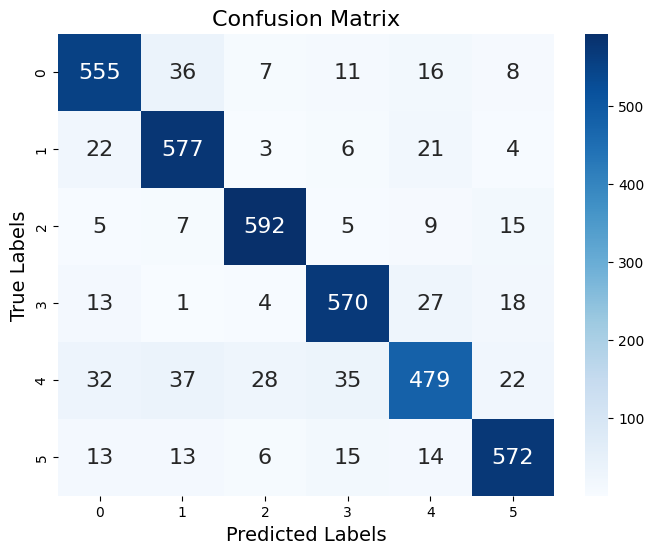

In [23]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np



# Compute confusion matrix
cm = confusion_matrix(true_labels, predictions)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=np.unique(true_labels), 
            yticklabels=np.unique(true_labels),
            annot_kws={"size": 16})  # Increase font size

plt.xlabel('Predicted Labels', fontsize=14)
plt.ylabel('True Labels', fontsize=14)
plt.title('Confusion Matrix', fontsize=16)
# Save the figure as an image (PNG format)
plt.savefig("confusion_matrix.png", dpi=300, bbox_inches='tight')

plt.show()


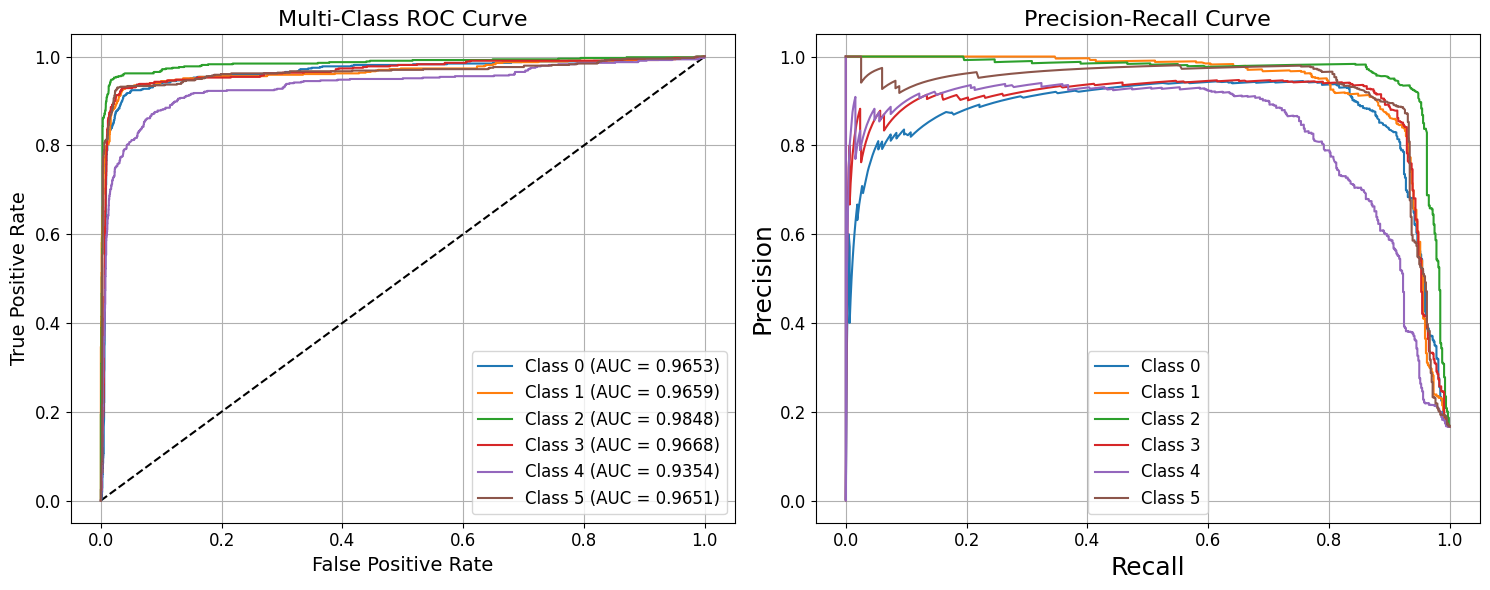

In [25]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.preprocessing import label_binarize
import numpy as np
import torch

# *Step 1: Convert True Labels to One-Hot Encoding (Required for Multi-Class)*
num_classes = len(set(true_labels))  # Number of classes
true_labels_one_hot = label_binarize(true_labels, classes=np.arange(num_classes))

# *Step 2: Get Softmax Probabilities for ROC & PR Curves*
model.eval()
all_probs = []
with torch.no_grad():
    for batch in test_loader:
        input_ids, attention_mask, labels = batch["input_ids"].to(device), batch["attention_mask"].to(device), batch["label"].to(device)
        outputs = model(input_ids, attention_mask)
        probs = torch.exp(outputs).cpu().numpy()  # Convert log-softmax to probabilities
        all_probs.extend(probs)

all_probs = np.array(all_probs)

# *Step 3 & 4: Plot ROC and Precision-Recall Curves Side by Side*
fig, axes = plt.subplots(1, 2, figsize=(15, 6))  # Create 1 row, 2 columns

# ---- Plot ROC Curve ----
axes[0].set_title("Multi-Class ROC Curve", fontsize=16)
axes[0].plot([0, 1], [0, 1], 'k--')  # Diagonal line for reference
axes[0].set_xlabel("False Positive Rate", fontsize=14)
axes[0].set_ylabel("True Positive Rate", fontsize=14)
axes[0].tick_params(axis='both', which='major', labelsize=12)
axes[0].grid()

for i in range(num_classes):
    fpr, tpr, _ = roc_curve(true_labels_one_hot[:, i], all_probs[:, i])
    roc_auc = auc(fpr, tpr)
    axes[0].plot(fpr, tpr, label=f"Class {i} (AUC = {roc_auc:.4f})")

axes[0].legend(fontsize=12)

# ---- Plot Precision-Recall Curve ----
axes[1].set_title("Precision-Recall Curve", fontsize=16)
axes[1].set_xlabel("Recall", fontsize=18)
axes[1].set_ylabel("Precision", fontsize=18)
axes[1].tick_params(axis='both', which='major', labelsize=12)
axes[1].grid()

for i in range(num_classes):
    precision, recall, _ = precision_recall_curve(true_labels_one_hot[:, i], all_probs[:, i])
    axes[1].plot(recall, precision, label=f"Class {i}")

axes[1].legend(fontsize=12)

plt.tight_layout()  # Adjust layout for better visualization
plt.show()
